In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [2]:
### changes in physics - seasonal avg
sst_delta = 0.5 #change in SST, deg/yr?
mld_delta = 10 #change in MLD, m/yr
ot_delta = 5 # change in OT, Sv/yr (SV = 1e6 m3/s)

#### gradients in BGC
grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

### mean ecosystem parameters
mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
diatconc = 1 # mean diatom concentration (umol/L)
efratio = 0.5

### carbonate system variables
mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
mn_SST = 2 #(oC)
mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
mn_DIC = 2120 # (umol/L)
mn_TA = 2290 # (ueq/L)
mn_pCO2 = 380 # (ppm)

# conversions/ geography
PgC_mol = 1.2e-14 # pgC/mol
SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask


In [3]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr

    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe

def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe


def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
        effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

        return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)


# Check duplication of CLQ's math in example problem 

In [4]:


dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
    effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)
print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_Fe}')
dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
    effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

# dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc)
# print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_OT_Fe, dfco2_pgCyr_MLD_Fe, CO2_tot = give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = True)


effect SST pgC/yr 0.3521232
effect MLD (TA, DIC, Fe) pgC/yr 0.3255478641509434, -0.10851595471698113, -0.0876934385685849
effect OT (TA, DIC, Fe) pgC/yr 0.227232, -0.07574399999999999, -0.08161321319999999
individual effects
effect SST pgC/yr 0.3521232
effect MLD (TA, DIC, Fe) pgC/yr 0.3255478641509434, -0.10851595471698113, -0.0876934385685849
effect OT (TA, DIC, Fe) pgC/yr 0.227232, -0.07574399999999999, -0.08161321319999999

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.3521232
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.21703190943396228
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.151488
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.1693066517685849
Total change in CO2 flux 0.5513364576653774


In [5]:

def make_yearlist(yrst, yrend, scen):
    
    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}cchem-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])
        
    return ylist

ty_1A = make_yearlist(1950,2099,'1A')
ty_1B = make_yearlist(1950,2099,'1B')


In [6]:
td_1A = xr.open_mfdataset(ty_1A)
td_1B = xr.open_mfdataset(ty_1B)

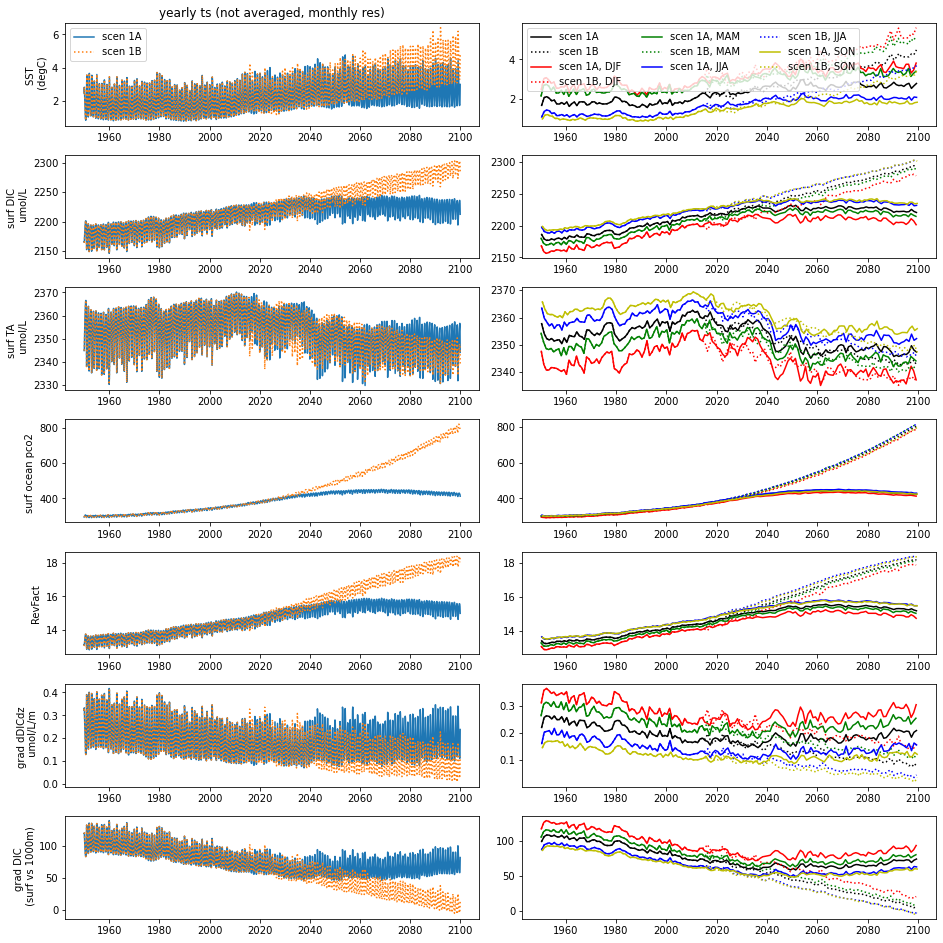

In [7]:
fact = 1.1
fig, axs = plt.subplots(7,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0*2].plot(td_1A.time_counter, td_1A.mn_SST.sel({'quantity': 'mean'}), label = 'scen 1A')
axs[1*2].plot(td_1A.time_counter, td_1A.mn_DIC.sel({'quantity': 'mean'}))
axs[2*2].plot(td_1A.time_counter, td_1A.mn_TA.sel({'quantity': 'mean'}))
axs[3*2].plot(td_1A.time_counter, td_1A.mn_pCO2.sel({'quantity': 'mean'}))
axs[4*2].plot(td_1A.time_counter, td_1A.mn_Revfact.sel({'quantity': 'mean'}))
axs[5*2].plot(td_1A.time_counter, td_1A.grad_dDICdz.sel({'quantity': 'mean'}))
axs[6*2].plot(td_1A.time_counter, td_1A.grad_DIC_surfdeep.sel({'quantity': 'mean'}))

axs[0*2].plot(td_1B.time_counter, td_1B.mn_SST.sel({'quantity': 'mean'}), linestyle = ':', label = 'scen 1B')
axs[1*2].plot(td_1B.time_counter, td_1B.mn_DIC.sel({'quantity': 'mean'}), linestyle = ':')
axs[2*2].plot(td_1B.time_counter, td_1B.mn_TA.sel({'quantity': 'mean'}), linestyle = ':')
axs[3*2].plot(td_1B.time_counter, td_1B.mn_pCO2.sel({'quantity': 'mean'}), linestyle = ':')
axs[4*2].plot(td_1B.time_counter, td_1B.mn_Revfact.sel({'quantity': 'mean'}), linestyle = ':')
axs[5*2].plot(td_1B.time_counter, td_1B.grad_dDICdz.sel({'quantity': 'mean'}), linestyle = ':')
axs[6*2].plot(td_1B.time_counter, td_1B.grad_DIC_surfdeep.sel({'quantity': 'mean'}), linestyle = ':')

axs[0].legend(loc = 'best')
ylabs = ['SST \n (degC)', 'surf DIC \n umol/L', 'surf TA \n umol/L', 'surf ocean pco2 ', 'RevFact ',\
        'grad dDICdz \n umol/L/m', 'grad DIC \n (surf vs 1000m)']
for i in range(0,7):
    axs[i*2].set_ylabel(ylabs[i])
axs[0].set_title('yearly ts (not averaged, monthly res)')


tvars = ['mn_SST','mn_DIC','mn_TA','mn_pCO2','mn_Revfact',\
       'grad_dDICdz','grad_DIC_surfdeep']
for i in range(0,7):
    
    axs[i*2+1].plot(td_1A.time_counter.groupby('time_counter.year').mean(),\
                    td_1A[tvars[i]].sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                    color = 'k', label = 'scen 1A')
    axs[i*2+1].plot(td_1A.time_counter.groupby('time_counter.year').mean(),\
                    td_1B[tvars[i]].sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                    color = 'k', linestyle = ':', label = 'scen 1B')
    cols = ['r','g','b','y']
    seas = ['DJF','MAM','JJA','SON']
    for c in range(0,4):
        axs[i*2+1].plot(td_1A.time_counter.sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .groupby('time_counter.year').mean(),\
                        td_1A[tvars[i]].sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .sel({'quantity': 'mean'}).groupby('time_counter.year').mean(),
                        color = cols[c], label = f'scen 1A, {seas[c]}')
        axs[i*2+1].plot(td_1A.time_counter.sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .groupby('time_counter.year').mean(),\
                        td_1B[tvars[i]].sel({'quantity': 'mean'}).sel(time_counter=(td_1B['time_counter.season'] == seas[c]))\
                        .groupby('time_counter.year').mean(),
                        color = cols[c], linestyle = ':', label = f'scen 1B, {seas[c]}')
axs[1].legend(ncol = 3, fontsize = 10, loc = 'best')# bbox_to_anchor = [1,1])        
plt.tight_layout()

In [8]:
## trends in changes:
periodar =  ['1950-2000','2000-2050','2050-2100']
seasonar = ['FY','DJF','MAM','JJA','SON']
quantityar = ['wind','sst','mld','ot']
# quantityh = [wspd_t, sst_t, mld_t, ot_t]
forcingar = ['ghg','ozone']
scenarioar = ['ssp1','ssp3']
    
    
changes = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc')
changes

q = changes.trend.loc[{'period':'2050-2100', 'season':'DJF', 'quantity': 'sst', \
                      'forcing': 'ghg', 'scenario': 'ssp3' }] 
print(q)



<xarray.DataArray 'trend' ()>
array(0.345653)
Coordinates:
    period    <U9 '2050-2100'
    season    <U3 'DJF'
    quantity  <U3 'sst'
    forcing   <U3 'ghg'
    scenario  <U4 'ssp3'
Attributes:
    units:      /decade
    long_name:  


In [9]:
yr = 1950
td = td_1A.sel(time_counter=slice(f'{yr}-01-01', f'{yr+49}-12-31'))


In [10]:
q = changes.trend.loc[{'period':'1950-2000', 'season':'DJF', 'quantity': 'sst', \
                      'forcing': 'ozone', 'scenario': 'ssp3' }] 
print(q)

<xarray.DataArray 'trend' ()>
array(-0.082849)
Coordinates:
    period    <U9 '1950-2000'
    season    <U3 'DJF'
    quantity  <U3 'sst'
    forcing   <U5 'ozone'
    scenario  <U4 'ssp3'
Attributes:
    units:      /decade
    long_name:  


In [12]:
verbose = True

datar = np.zeros([3,5,6,2,2])
data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
{'units': '/yr',
'long_name':''}),
}
# define coordinates
coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
          'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
          'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                      'CO2_OT_phys_chem','CO2_MLD_bio',\
                                      'CO2_OT_bio','CO2_tot']),
          'forcing': (['forcing'], ['ghg','ozone']),
          'scenario': (['scenario'], ['ssp1','ssp3']),
          
         }
attrs = {'made in':'SOZONE/windAnalyis/oceanFields/synthesisFigure.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)

#ds.sel(period='1950-2000', season='fy', quantity = 'sst', forcing = 'ghg').data = 10
ds.trend.loc[{'period':'1950-2000', 'season':'FY', \
              'quantity':'CO2_SST', 'forcing' : 'ghg', 'scenario' : 'ssp1'}] = 0

periodar =  ['1950-2000','2000-2050','2050-2100']
psta = [1950,2000,2050]; pen = [2000,2050,2100]
seasonar = ['FY','DJF','MAM','JJA','SON']
mu_L_ar = [0.5, 0.5,0.5,0.5,0.5,]
diatar = [1, 1, 1, 1, 1]

forcingar = ['ghg','ozone']
scenarioar = ['ssp1','ssp3']

for p in periodar:
    ind = 0 
    tpe = int(p[0:4])
    for s in seasonar:
        diatconc = (diatar[ind])
        mu_L = mu_L_ar[ind]
        if verbose:
            print(f'diatoms {diatconc}, mu_L {mu_L}')
        ind = ind+1
        for f in forcingar:
            for sc in scenarioar:
                
                sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                  'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                  'forcing': f, 'scenario': sc }].values*5  # / decade to / 50 yrs  
                ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                  'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                if verbose:
                    print(f'{p} (starts {tpe}), {s}, {f}, {sc}, temp delta {sst_t}, mld delta {mld_t}, ot delta {ot_t}')
                
                if np.isnan(sst_t): sst_t = 0
                if np.isnan(mld_t): mld_t = 0
                if np.isnan(ot_t): ot_t = 0
                    
                if sc == 'ssp1': td = td_1A;
                if sc == 'ssp3': td = td_1B;
                td = td.sel(time_counter=slice(f'{tpe}-01-01', f'{tpe+49}-12-31'))

                if s == 'FY':
                    td = td.groupby('time_counter.year').mean()
                else:
                    td = td.sel(time_counter=(td['time_counter.season'] == s)).\
                    groupby('time_counter.year').mean()

                mn_kg = 0.065; mn_pCO2 = td.mn_pCO2[:,0].mean().values; sst_delta = sst_t; 
                PgC_mol = 1.2e-14 # pgC/mol 
                SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask
                mld_delta = mld_t; grad_dDICdz = td.grad_dDICdz[:,0].mean().values;
                mn_Revfact = td.mn_Revfact[:,0].mean().values; 
                grad_DIC_surfdeep = td.grad_DIC_surfdeep[:,0].mean().values;
                mn_DIC = td.mn_DIC[:,0].mean().values; ot_delta = ot_t;
                
                
                
                if verbose:
                    print(f'diatoms: {diatconc}, muL {mu_L}, mn_pCO2 {mn_pCO2}')
                    print(f'sst_delta: {sst_t}, mld_delta = {mld_t}')
                    print(f'grad_dicdz: {grad_dDICdz}, mn_Revfact = {mn_Revfact}')
                    print(f'grad_DIC_surfdeep: {grad_DIC_surfdeep}, mn_DIC = {mn_DIC}')
                    print(f'ot_delta: {ot_t}')
                
                #if verbose:
#                 dmudFe = 0
#                 mu_L = 
#                 diatconc = 
#                 grad_dFev = 
#                 efratio = 

                grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
                grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)
                ### mean ecosystem parameters
                dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
                efratio = 0.5
                
                
                CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)
                
    
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                  'forcing': f, 'scenario': sc }] = CO2_SST
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                  'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                  'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                  'forcing': f, 'scenario': sc }] = dfco2_pgCyr_MLD_Fe
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                  'forcing': f, 'scenario': sc }] = dfco2_pgCyr_OT_Fe
                ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                  'forcing': f, 'scenario': sc }] = CO2_tot



                if verbose:
                    print()
                    print()


diatoms 1, mu_L 0.5
1950-2000 (starts 1950), FY, ghg, ssp1, temp delta 0.03761499504220941, mld delta -3.201252840678581, ot delta -1.4252295483617514
diatoms: 1, muL 0.5, mn_pCO2 314.7495608079569
sst_delta: 0.03761499504220941, mld_delta = -3.201252840678581
grad_dicdz: 0.22489127148249125, mn_Revfact = 13.658651409553721
grad_DIC_surfdeep: 96.50302903962745, mn_DIC = 2189.1437477174004
ot_delta: -1.4252295483617514
individual effects
effect SST pgC/yr 0.02194154377765384
effect MLD (TA, DIC, Fe) pgC/yr -0.06550467533623629, 0.021834891778745428, 0.010984492168317327
effect OT (TA, DIC, Fe) pgC/yr -0.05208875814792997, 0.017362919382643324, 0.011631756298938731

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.02194154377765384
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.04366978355749086
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.03472583876528665
Change in CO2 flux due to MLD+Overturning change (ec

diatoms: 1, muL 0.5, mn_pCO2 315.31976661148127
sst_delta: 0.04532324316428002, mld_delta = -2.867498678797512
grad_dicdz: 0.2733982787297726, mn_Revfact = 13.5133522013401
grad_DIC_surfdeep: 103.65692542226493, mn_DIC = 2182.021223534233
ot_delta: 1.2253026916815764
individual effects
effect SST pgC/yr 0.026485807256194722
effect MLD (TA, DIC, Fe) pgC/yr -0.07093088395396742, 0.023643627984655805, 0.009784077431943863
effect OT (TA, DIC, Fe) pgC/yr 0.04810164747745219, -0.016033882492484063, -0.010000088981074233

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.026485807256194722
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.04728725596931162
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.03206776498496813
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.00021601154913036998
Total change in CO2 flux 0.011050304722720868


1950-2000 (starts 1950), MAM, ghg, ssp3, temp delta 0.045323243

diatoms: 1, muL 0.5, mn_pCO2 316.57734873695927
sst_delta: -0.02196195443691383, mld_delta = -2.7164764701344017
grad_dicdz: 0.13976918516261772, mn_Revfact = 13.900241370802883
grad_DIC_surfdeep: 82.2018063598627, mn_DIC = 2203.4226146437713
ot_delta: 0.3319657232835816
individual effects
effect SST pgC/yr -0.01288522073710475
effect MLD (TA, DIC, Fe) pgC/yr -0.03513199444023217, 0.011710664813410722, 0.00947919935669799
effect OT (TA, DIC, Fe) pgC/yr 0.01033458032622568, -0.003444860108741893, -0.0027092789349435144

--summary (in PgC/yr)
Change in CO2 flux due to SST change -0.01288522073710475
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.023421329626821447
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.006889720217483786
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0067699204217544755
Total change in CO2 flux -0.022646909724687934


1950-2000 (starts 1950), SON, ghg, ssp3, temp delta -0.021

diatoms: 1, muL 0.5, mn_pCO2 384.32117218413646
sst_delta: 0.5214673113258665, mld_delta = 0.06650534514857048
grad_dicdz: 0.24542899878576685, mn_Revfact = 14.481384555847754
grad_DIC_surfdeep: 83.39332250032965, mn_DIC = 2205.208324737206
ot_delta: 1.2199217024095619
individual effects
effect SST pgC/yr 0.3714175652822339
effect MLD (TA, DIC, Fe) pgC/yr 0.0019086146304337014, -0.0006362048768112338, -0.0002932733889940977
effect OT (TA, DIC, Fe) pgC/yr 0.0385284444479315, -0.012842814815977165, -0.009956172998605852

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.3714175652822339
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.0012724097536224678
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.025685629631954334
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.01024944638759995
Total change in CO2 flux 0.38812615828021074


2000-2050 (starts 2000), DJF, ghg, ssp3, temp delta 0.591791047

diatoms: 1, muL 0.5, mn_pCO2 395.48243335374667
sst_delta: 0.49080153047959546, mld_delta = -4.206887534689577
grad_dicdz: 0.12421115795556242, mn_Revfact = 15.047042451573635
grad_DIC_surfdeep: 59.23772919412265, mn_DIC = 2229.3901264781625
ot_delta: 0.8399043137525064
individual effects
effect SST pgC/yr 0.35972791869855736
effect MLD (TA, DIC, Fe) pgC/yr -0.06462414802065392, 0.021541382673551306, 0.01962070034027094
effect OT (TA, DIC, Fe) pgC/yr 0.01884284407799021, -0.006280948025996736, -0.006854728982588298

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.35972791869855736
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.043082765347102606
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.012561896051993473
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.012765971357682643
Total change in CO2 flux 0.3419730207611309


2000-2050 (starts 2000), JJA, ghg, ssp3, temp delta 0.587768370696

diatoms: 1, muL 0.5, mn_pCO2 436.8277370215008
sst_delta: 0.08791858358111422, mld_delta = 2.071266452022858
grad_dicdz: 0.1851154767845128, mn_Revfact = 15.421329012647954
grad_DIC_surfdeep: 65.91955432695339, mn_DIC = 2226.384960108926
ot_delta: -0.3579225847923118
individual effects
effect SST pgC/yr 0.07117572973454438
effect MLD (TA, DIC, Fe) pgC/yr 0.05375161268685237, -0.017917204228950788, -0.010950376555937759
effect OT (TA, DIC, Fe) pgC/yr -0.008935556519253427, 0.002978518839751142, 0.002921121222175002

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.07117572973454438
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.03583440845790158
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.005957037679502285
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.008029255333762756
Total change in CO2 flux 0.09302384517918091


2050-2100 (starts 2050), FY, ghg, ssp3, temp delta 1.5602481934538

diatoms: 1, muL 0.5, mn_pCO2 439.5535047689411
sst_delta: 0.07277305551717296, mld_delta = 1.1138681114720246
grad_dicdz: 0.2275985926365622, mn_Revfact = 15.28398320967443
grad_DIC_surfdeep: 71.75430679145151, mn_DIC = 2220.541561748462
ot_delta: -3.0772173170300037
individual effects
effect SST pgC/yr 0.059282074967103936
effect MLD (TA, DIC, Fe) pgC/yr 0.03553642896818763, -0.011845476322729212, -0.005888226349514853
effect OT (TA, DIC, Fe) pgC/yr -0.08362273766130195, 0.02787424588710065, 0.025114159295750164

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.059282074967103936
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.023690952645458417
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.0557484917742013
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.019225932946235313
Total change in CO2 flux 0.04645046878459637


2050-2100 (starts 2050), MAM, ghg, ssp3, temp delta 1.65412450106294

diatoms: 1, muL 0.5, mn_pCO2 436.6781142605879
sst_delta: 0.11529479484500921, mld_delta = 1.963378866677517
grad_dicdz: 0.10934500404252523, mn_Revfact = 15.662887629639052
grad_DIC_surfdeep: 53.703756180543024, mn_DIC = 2238.6212705192415
ot_delta: -0.3402815600614068
individual effects
effect SST pgC/yr 0.09330655737501103
effect MLD (TA, DIC, Fe) pgC/yr 0.030390422448225797, -0.010130140816075267, -0.010481370601286656
effect OT (TA, DIC, Fe) pgC/yr -0.006920879985667718, 0.0023069599952225727, 0.0027771471509320193

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.09330655737501103
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.02026028163215053
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.004613919990445145
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.007704223450354637
Total change in CO2 flux 0.10124869556636178


2050-2100 (starts 2050), SON, ghg, ssp3, temp delta 1.404286

In [13]:
# #sst_delta = 0.4
# diatconc = 1
# mu_L = 0.4
# # mld_delta = 10
# # ot_delta = 7

# grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
# grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)
# ### mean ecosystem parameters
# dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
# efratio = 0.5

# sst_delta= -0.4142469594647723;
# mld_delta = 10.438048895157475;
# grad_dDICdz=  0.31436163890649854;
# mn_Revfact = 13.329190007422358
# grad_DIC_surfdeep: 114.44469289753661;
# mn_DIC = 2171.191053323466
# ot_delta: 6.989182008882986

# CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
# dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
# give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
# mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
# ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


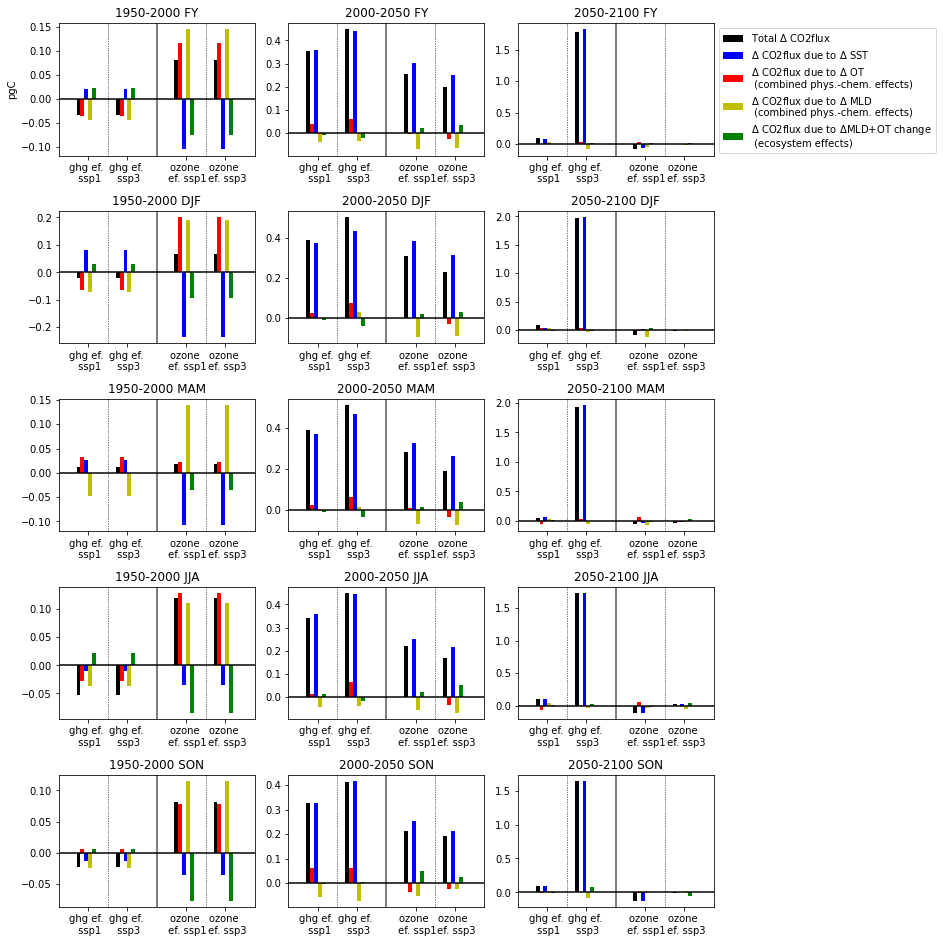

In [14]:
fact = 1.1
fig, axs = plt.subplots(5,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
seasonar = ['FY','FY','FY',\
            'DJF','DJF','DJF',\
            'MAM', 'MAM', 'MAM',\
            'JJA','JJA','JJA',\
            'SON','SON','SON']
periodar = ['1950-2000','2000-2050','2050-2100']
for i in range(0,15):
    
    per = i%3
    p = periodar[per]
    s = seasonar[i]
    fs = ['ghg','ghg','ozone','ozone'];
    scs = ['ssp1','ssp3','ssp1','ssp3']
    inds = [1,3,6,8]
    for x in range(4):
        f = fs[x]; sc = scs[x]; ind = inds[x]
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]
        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 
        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 
        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 
        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]
        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ms = 7
        if ind ==1:
            axs[i].bar(ind,CO2_tot,width = 0.2, color = 'k',\
                        label = 'Total $\Delta$ CO2flux') 
            axs[i].bar(ind+0.4,CO2_SST,width = 0.2, color = 'b',\
                        label = '$\Delta$ CO2flux due to $\Delta$ SST')
            axs[i].bar(ind+0.2,CO2_OT_phys_chem,width = 0.2, color = 'r',\
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)')    
            axs[i].bar(ind+0.6,CO2_MLD_phys_chem,width = 0.2, color = 'y',\
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
            axs[i].bar(ind+0.8,CO2_MLD_bio+CO2_OT_bio,width = 0.2, color = 'green',\
                        label = '$\Delta$ CO2flux due to $\Delta$MLD+OT change \n (ecosystem effects)')  
            axs[i].axvline(x = 5, linestyle = ':', linewidth = 0.7)
            
        else:
            axs[i].bar(ind,CO2_tot,width = 0.2, color = 'k')
            axs[i].bar(ind+0.4,CO2_SST,width = 0.2, color = 'b',\
                        )
            axs[i].bar(ind+0.2,CO2_OT_phys_chem,width = 0.2, color = 'r',\
                        )    
            axs[i].bar(ind+0.6,CO2_MLD_phys_chem,width = 0.2, color = 'y',\
                        )   
            axs[i].bar(ind+0.8,CO2_MLD_bio+CO2_OT_bio,width = 0.2, color = 'green',\
                        )  
            axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
            axs[i].axvline(x = 2.5, linestyle = ':', linewidth = 0.9, color = 'grey')
            axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')
                        
    axs[2].legend(bbox_to_anchor = [1,1], fontsize = 10)
    
    axs[i].set_xticks([1.5,3.5,6.5,8.5])
    axs[i].set_xlim([0,10])
    axs[i].set_xticklabels(['ghg ef. \n ssp1','ghg ef. \n ssp3','ozone \n ef. ssp1','ozone \n ef. ssp3'])
    axs[i].set_title(f'{p} {s}')
    axs[0].set_ylabel('pgC')
    axs[i].axhline(y=0, color = 'k')
    
    plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


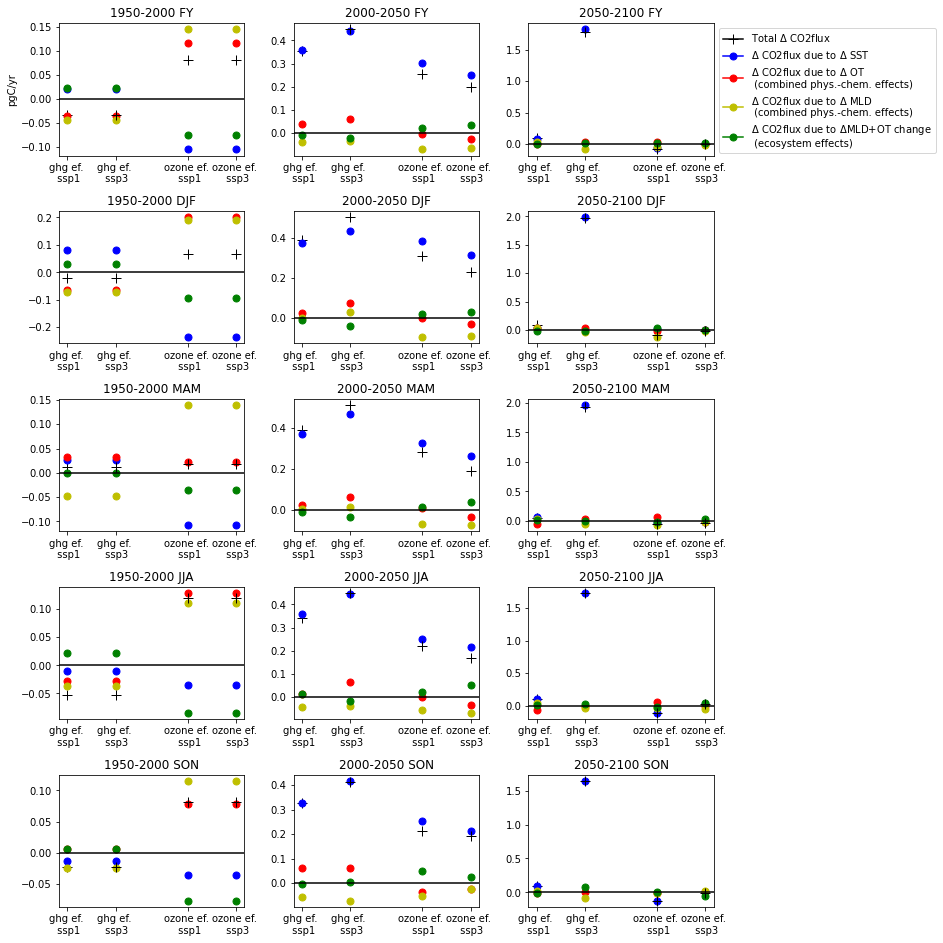

In [15]:
fact = 1.1
fig, axs = plt.subplots(5,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
seasonar = ['FY','FY','FY',\
            'DJF','DJF','DJF',\
            'MAM', 'MAM', 'MAM',\
            'JJA','JJA','JJA',\
            'SON','SON','SON']
periodar = ['1950-2000','2000-2050','2050-2100']
for i in range(0,15):
    
    per = i%3
    p = periodar[per]
    s = seasonar[i]
    fs = ['ghg','ghg','ozone','ozone'];
    scs = ['ssp1','ssp3','ssp1','ssp3']
    inds = [1,2,3.5,4.5]
    for x in range(4):
        f = fs[x]; sc = scs[x]; ind = inds[x]
        CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }]
        CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] 
        CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] 
        CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] 
        CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }]
        CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] 
        
        ms = 7
        if ind ==1:
            axs[i].plot(ind,CO2_tot,marker = '+', markersize = ms+3, color = 'k',\
                        label = 'Total $\Delta$ CO2flux') 
            axs[i].plot(ind,CO2_SST,marker = 'o', markersize = ms, color = 'b',\
                        label = '$\Delta$ CO2flux due to $\Delta$ SST')
            axs[i].plot(ind,CO2_OT_phys_chem,marker = 'o', markersize = ms, color = 'r',\
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)')    
            axs[i].plot(ind,CO2_MLD_phys_chem,marker = 'o', markersize = ms, color = 'y',\
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
            axs[i].plot(ind,CO2_MLD_bio+CO2_OT_bio,marker = 'o', markersize = ms, color = 'green',\
                        label = '$\Delta$ CO2flux due to $\Delta$MLD+OT change \n (ecosystem effects)')  

        else:
            axs[i].plot(ind,CO2_SST,marker = 'o', markersize = ms, color = 'b',\
                        )
            axs[i].plot(ind,CO2_OT_phys_chem,marker = 'o', markersize = ms, color = 'r',\
                        )    
            axs[i].plot(ind,CO2_MLD_phys_chem,marker = 'o', markersize = ms, color = 'y',\
                        )   
            axs[i].plot(ind,CO2_MLD_bio+CO2_OT_bio,marker = 'o', markersize = ms, color = 'green',\
                        )  
            axs[i].plot(ind,CO2_tot,marker = '+', markersize = ms+3, color = 'k',\
                        )  
    axs[2].legend(bbox_to_anchor = [1,1], fontsize = 10)
    
    axs[i].set_xticks([1,2,3.5,4.5])
    axs[i].set_xticklabels(['ghg ef. \n ssp1','ghg ef. \n ssp3','ozone ef. \n ssp1','ozone ef. \n ssp3'])
    axs[i].set_title(f'{p} {s}')
    axs[0].set_ylabel('pgC/yr')
    axs[i].axhline(y=0, color = 'k')
    
    plt.tight_layout()

In [16]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary'
wspd_t = xr.open_dataset(f'{tdir}/wspd-medusa-50yrtrends.nc')
ot_t = xr.open_dataset(f'{tdir}/ot-medusa-50yrtrends.nc')
sst_t = xr.open_dataset(f'{tdir}/sst-medusa-50yrtrends.nc')
mld_t = xr.open_dataset(f'{tdir}/mld-medusa-50yrtrends.nc')

mld_t

<xarray.Dataset>
Dimensions:   (forcing: 2, period: 3, scenario: 2, season: 5)
Coordinates:
  * period    (period) object '1950-2000' '2000-2050' '2050-2100'
  * season    (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
  * forcing   (forcing) object 'ghg' 'ozone'
  * scenario  (scenario) object 'ssp1' 'ssp3'
Data variables:
    trend     (period, season, forcing, scenario) float64 ...
    sig       (period, season, forcing, scenario) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/oceanFields/bargraph-with-50yrtrends.ipynb
    desc:     medusa trends in quantity of interest, south of -50 south, decadal

In [17]:
test = False
if test:
    
    sst_delta = 0.01 #change in SST, deg/yr?
    mld_delta = 1 #change in MLD, m/yr
    ot_delta = 0.02 # change in OT, Sv/yr (SV = 1e6 m3/s)

    #### gradients in BGC
    grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
    grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
    mn_SST = 2 #(oC)
    mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
    mn_DIC = 2120 # (umol/L)
    mn_TA = 2290 # (ueq/L)
    mn_pCO2 = 380 # (ppm)


    yr = 1950
    nam = f'test-{yr}.nc'
    times = pd.date_range(f"{yr}/01/01",f"{yr}/12/11",freq='MS')#,closed='left')
    print(times)
    data_vars = {
        'sst_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                 {'units': ''}),                       
       'mld_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'grad_dDICdz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFedz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFev': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'dmudFe': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'diatconc': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_SST': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_Revfact': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_DIC': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_TA': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_pCO2': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),




    }

    coords = {'time_counter': (['time_counter'], times),
              'quantity': (['mean', 'stdev', 'max', 'min']),
            #   'stdev': (['stdev'], 'stdev'),
            #   'max': (['max'], 'max'),
            #   'min': (['min'], 'min'),


    }
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/sketch.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
# ds.to_netcdf(savenam)

In [20]:

test = False
if test:
    
    sst_delta = 0.01 #change in SST, deg/yr?
    mld_delta = 1 #change in MLD, m/yr
    ot_delta = 0.02 # change in OT, Sv/yr (SV = 1e6 m3/s)

    #### gradients in BGC
    grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
    grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
    mn_SST = 2 #(oC)
    mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
    mn_DIC = 2120 # (umol/L)
    mn_TA = 2290 # (ueq/L)
    mn_pCO2 = 380 # (ppm)


    yr = 1950
    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    nam = f'{tdir}dat.nc'
    
    data_vars = {


            ### bgc gradients
        'grad_dDICdz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFedz': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'grad_dFev': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'dmudFe': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'diatconc': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_SST': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_Revfact': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_DIC': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_TA': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),
        'mn_pCO2': (['period','season','scenario'], np.zeros([3,5,2]),
                {'units': ''}),


    }

    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'scenario': (['scenario'], ['ssp1','ssp3']),
             }
    
    
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/sketch.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
# ds.to_netcdf(savenam)

In [ ]:
test = True
if test:
    
    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    nam = f'{tdir}dat.nc'
    times = pd.date_range(f"{yr}/01/01",f"{yr}/12/11",freq='MS')#,closed='left')
    print(times)
    data_vars = {
        'sst_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                 {'units': ''}),                       
       'mld_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'grad_dDICdz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFedz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFev': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'dmudFe': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'diatconc': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_SST': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_Revfact': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_DIC': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_TA': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_pCO2': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),




    }

    coords = {'time_counter': (['time_counter'], times),
              'quantity': (['mean', 'stdev', 'max', 'min']),
            #   'stdev': (['stdev'], 'stdev'),
            #   'max': (['max'], 'max'),
            #   'min': (['min'], 'min'),


    }
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/sketch.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
# ds.to_netcdf(savenam)

In [ ]:
test = False
if test:
    
    sst_delta = 0.01 #change in SST, deg/yr?
    mld_delta = 1 #change in MLD, m/yr
    ot_delta = 0.02 # change in OT, Sv/yr (SV = 1e6 m3/s)

    #### gradients in BGC
    grad_dDICdz = 0.28 # (umol/L/m) average between 0-100m depth and 100-200m
    grad_DIC_surfdeep = 120 #umol/L between surface and 1000m depth
    grad_dFedz = 0.0007 #(nmol/L/m) (nmol/L/m)
    grad_dFev = 0.4 # deep minus surface ocean (nmol/L) between surface and 1000m depth (based on Tagliabue 2012 database)

    ### mean ecosystem parameters
    mu_L = 1 # 0-1 depending on month  (Light limitation; no units)
    dmudFe = 0.59 # (1/d/(nmolFe/L)) see worksheet Fer parameters "C-estimations-v2"
    diatconc = 1 # mean diatom concentration (umol/L)

    ### carbonate system variables
    mn_kg = 0.065 # (mol/m2/yr/ppm) xx-TJ I don't know what this is
    mn_SST = 2 #(oC)
    mn_Revfact = 14 # Definition: R=(dCO2/CO2)/(dDIC/DIC)
    mn_DIC = 2120 # (umol/L)
    mn_TA = 2290 # (ueq/L)
    mn_pCO2 = 380 # (ppm)


    yr = 1950
    nam = f'test-{yr}.nc'
    times = pd.date_range(f"{yr}/01/01",f"{yr}/12/11",freq='MS')#,closed='left')
    print(times)
    data_vars = {
        'sst_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                 {'units': ''}),                       
       'mld_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ozone': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_ghg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

        'sst_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mld_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'ot_delta_tot': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'grad_dDICdz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_DIC_surfdeep': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFedz': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'grad_dFev': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### bgc gradients
        'mu_L': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'dmudFe': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'diatconc': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),

            ### carbonate system variables
        'mn_kg': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_SST': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_Revfact': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_DIC': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_TA': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),
        'mn_pCO2': (['time_counter', 'quantity'], np.zeros([12,4]),
                {'units': ''}),




    }

    coords = {'time_counter': (['time_counter'], times),
              'quantity': (['mean', 'stdev', 'max', 'min']),
            #   'stdev': (['stdev'], 'stdev'),
            #   'max': (['max'], 'max'),
            #   'min': (['min'], 'min'),


    }
    # define global attributes
    attrs = {'made in':'BOE-SO-carbon/sketch.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
# ds.to_netcdf(savenam)